# AJ_0071 - Allele-specific ATAC-seq analysis

In [ ]:
# Disclaimer - old code, didn't know R well, many things aren't optimal. But it works, and it works fast.

In [1]:
library(readr)
library(DiffBind)
library(DESeq2)
library(dplyr)
library(tidyr)
library(ggplot2)
library(viridis)
library(ggridges)
library(readxl)

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors

Atta

In [2]:
setwd("/staging/leuven/stg_00041/Adrian/AJ_0071_XCR_ATAC_allele")

In [3]:
### Question is whether globally, dynamics of chromatin accessibility changes reflect successive steps from MEFs to iPSCs.
### Questions is now what are the dynamics of chromatin opening during XCR?

### Create a count matrix based on opened regions and plot PCA and similarity matrix

# Read the sample sheet

samples <- read_delim("AJ_71_allele_sampleSheet.csv",";", escape_double = FALSE, trim_ws = TRUE)

# Read the peaksets (Meaning associate peaks with the metadata and store everything in DBA object)

ATAC_Allele_DBA <- dba(sampleSheet = samples)
ATAC_Allele_DBA

Parsed with column specification:
cols(
  SampleID = col_character(),
  Tissue = col_character(),
  Factor = col_character(),
  Condition = col_character(),
  Treatment = col_character(),
  Replicate = col_character(),
  bamReads = col_character(),
  Peaks = col_character(),
  PeakCaller = col_character(),
  PeakFormat = col_character()
)
Warning message:
"Unknown or uninitialised column: 'ScoreCol'."Warning message:
"Unknown or uninitialised column: 'LowerBetter'."Warning message:
"Unknown or uninitialised column: 'Filter'."Warning message:
"Unknown or uninitialised column: 'ControlID'."Warning message:
"Unknown or uninitialised column: 'bamControl'."Warning message:
"Unknown or uninitialised column: 'Counts'."Warning message in message(as.character(samples$SampleID[i]), " ", as.character(samples$Tissue[i]), :
"NAs introduced by coercion"Day0_M Day0 XX Mus WT NA macs
Warning message:
"Unknown or uninitialised column: 'bamControl'."Warning message in cbind(NULL, c(sampID, tissue, facto

12 Samples, 408372 sites in matrix (909371 total):
        ID Tissue Factor Condition Treatment Caller Intervals
1   Day0_M   Day0     XX       Mus        WT   macs    179773
2   Day0_C   Day0     XX      Cast        WT   macs    215267
3   Day8_M   Day8     XX       Mus        WT   macs    187028
4   Day8_C   Day8     XX      Cast        WT   macs    224805
5   Day9_M   Day9     XX       Mus        WT   macs    194047
6   Day9_C   Day9     XX      Cast        WT   macs    231324
7  Day10_M  Day10     XX       Mus        WT   macs    190279
8  Day10_C  Day10     XX      Cast        WT   macs    228003
9  Day12_M  Day12     XX       Mus        WT   macs    300000
10 Day12_C  Day12     XX      Cast        WT   macs    219791
11 iPSCs_M  iPSCs     XX       Mus        WT   macs    300000
12 iPSCs_C  iPSCs     XX      Cast        WT   macs    208509

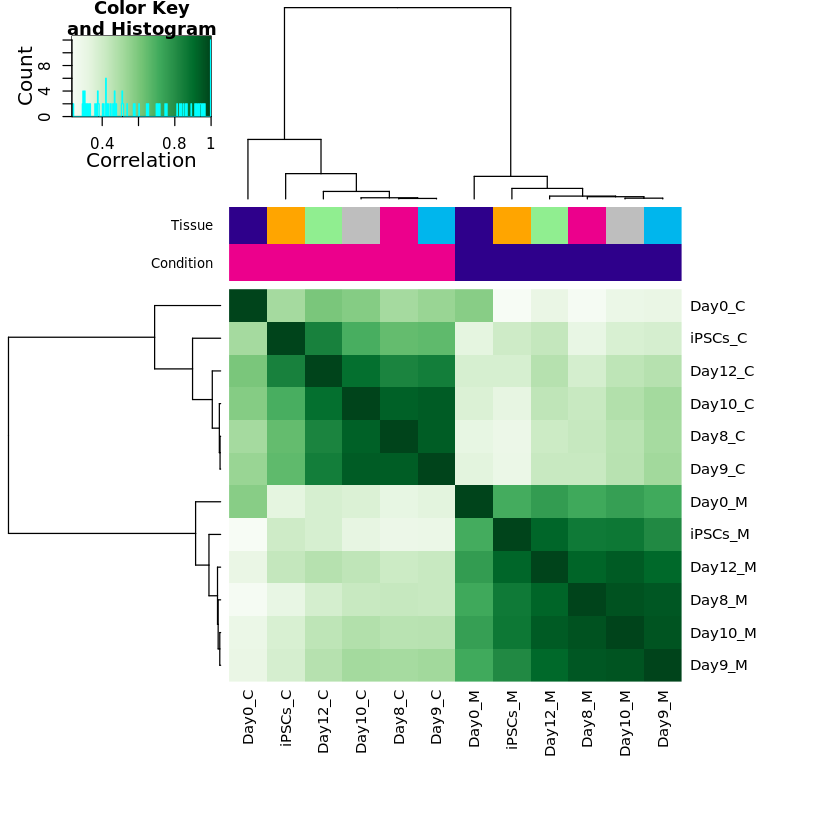

In [5]:
#correlation heatmap can be generated which gives an initial
#clustering of the samples using the cross-correlations of each row of the binding matrix:
plot(ATAC_Allele_DBA)

#### Figure 1: Correlation heatmap, using occupancy (peak caller score) data.
#### It seems that samples cluster as expected. Day 0 very far away from  everything else, and then Day 8 and 9, later to Day 10, and 12 most #### similar with iPSCs. Although Day 12 is still relatively dissimilar to iPSCs.

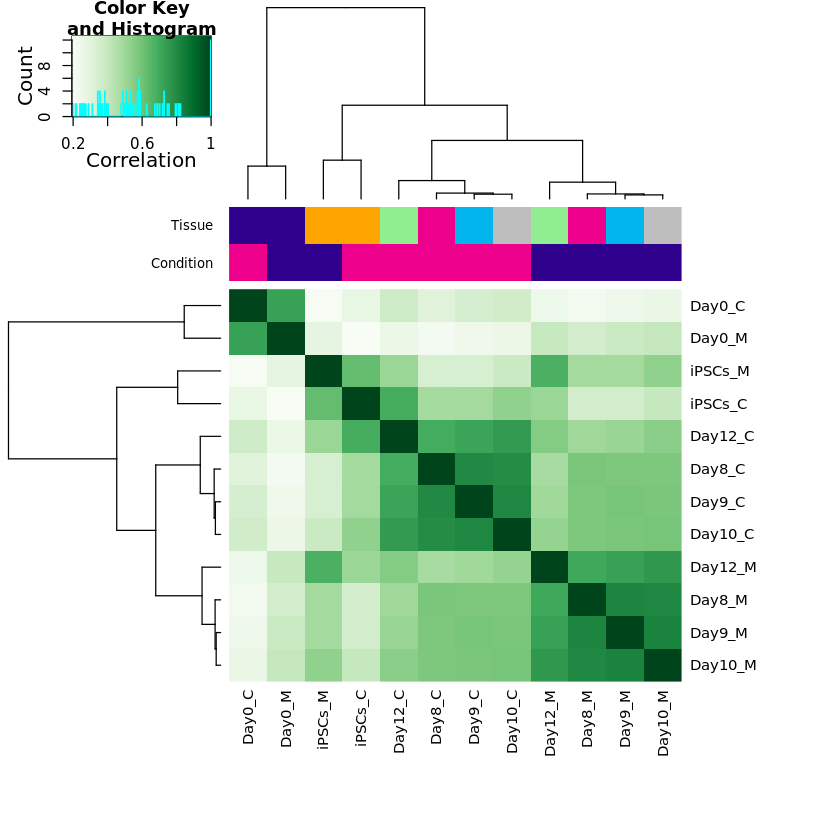

In [4]:
#### The next step is to calculate a binding matrix with scores based on read counts for every
#### sample (affinity scores), rather than confidence scores for only those peaks called in a specific
#### sample (occupancy scores).
ATAC_Allele_DBA_rawCounts <- dba.count(ATAC_Allele_DBA, score = DBA_SCORE_READS) # score = raw read count (without normalization)

plot(ATAC_Allele_DBA_rawCounts)
#### Figure 2: Correlation heatmap, using affinity (read count) data

In [5]:
# Retrieve the peakset with raw read counts

peaks.init.ranges_allele <- dba.peakset(ATAC_Allele_DBA_rawCounts, bRetrieve = TRUE)
peaks.init.ranges_allele

GRanges object with 408372 ranges and 12 metadata columns:
         seqnames            ranges strand |    Day0_M    Day0_C    Day8_M
            <Rle>         <IRanges>  <Rle> | <numeric> <numeric> <numeric>
       1        1   3046042-3046267      * |         1         1         1
       2        1   3046446-3046917      * |         1         1        21
       3        1   3215905-3216127      * |         1         3         2
       4        1   3250793-3251095      * |         1         1         1
       5        1   3251341-3251716      * |         1         1         3
     ...      ...               ...    ... .       ...       ...       ...
  408368        Y 90807926-90808107      * |         1         1         8
  408369        Y 90810198-90810481      * |         2         1        19
  408370        Y 90811326-90811559      * |         2         1         9
  408371        Y 90812012-90812264      * |         1         1        12
  408372        Y 90825238-90825392      

In [6]:
# Create clean matrix with GRanges peakID with only X chromosome

peaks.init.ranges_allele_chrX <- peaks.init.ranges_allele[seqnames(peaks.init.ranges_allele) == "X"]
peaks.init.ranges_allele_Auto <- peaks.init.ranges_allele[seqnames(peaks.init.ranges_allele) != "X" & 
                                                            seqnames(peaks.init.ranges_allele) != "Y" &
                                                            seqnames(peaks.init.ranges_allele) != "MT"] 



In [7]:
DF_allele_Auto <- as.data.frame(peaks.init.ranges_allele_Auto@elementMetadata)
ranges_df <- as.data.frame(peaks.init.ranges_allele_Auto@ranges)
seqnames_df <- as.data.frame(peaks.init.ranges_allele_Auto@seqnames)
DF_allele_Auto <- cbind(DF_allele_Auto,ranges_df)
DF_allele_Auto_chr <- cbind(DF_allele_Auto,seqnames_df)

In [16]:
setwd("/ddn1/vol1/staging/leuven/stg_00041/Irene/homer_results/nonallelic_regions_X/")

In [17]:
DF_allele_Auto_chr <- read.delim("DF_allele_Auto_chr.txt")

In [18]:
head(DF_allele_Auto_chr)

Day0_M,Day0_C,Day8_M,Day8_C,Day9_M,Day9_C,Day10_M,Day10_C,Day12_M,Day12_C,iPSCs_M,iPSCs_C,start,end,width,names,value
1,1,1,1,7,1,2,1,5,1,1,2,3046042,3046267,226,1,1
1,1,21,12,16,9,13,9,3,4,1,2,3046446,3046917,472,2,1
1,3,2,1,1,2,5,1,4,2,1,1,3215905,3216127,223,3,1
1,1,1,1,1,1,1,5,1,3,5,2,3250793,3251095,303,4,1
1,1,3,1,2,1,1,4,3,1,5,1,3251341,3251716,376,5,1
2,2,1,6,1,1,1,1,1,1,4,1,3285287,3285526,240,6,1


In [19]:
nrow(DF_allele_Auto_chr)

[1] 400930

In [20]:
peaks.init.ranges_allele_Auto$Day0_sum <- peaks.init.ranges_allele_Auto$Day0_M + peaks.init.ranges_allele_Auto$Day0_C
peaks.init.ranges_allele_Auto$Day8_sum <- peaks.init.ranges_allele_Auto$Day8_M + peaks.init.ranges_allele_Auto$Day8_C
peaks.init.ranges_allele_Auto$Day9_sum <- peaks.init.ranges_allele_Auto$Day9_M + peaks.init.ranges_allele_Auto$Day9_C
peaks.init.ranges_allele_Auto$Day10_sum <- peaks.init.ranges_allele_Auto$Day10_M + peaks.init.ranges_allele_Auto$Day10_C
peaks.init.ranges_allele_Auto$Day12_sum <- peaks.init.ranges_allele_Auto$Day12_M + peaks.init.ranges_allele_Auto$Day12_C
peaks.init.ranges_allele_Auto$iPSCs_sum <- peaks.init.ranges_allele_Auto$iPSCs_M + peaks.init.ranges_allele_Auto$iPSCs_C

In [21]:
peaks.init.ranges_allele_Auto$Day0_M = ifelse(peaks.init.ranges_allele_Auto$Day0_sum>9,
                                                peaks.init.ranges_allele_Auto$Day0_M,
                                                NA)
peaks.init.ranges_allele_Auto$Day8_M = ifelse(peaks.init.ranges_allele_Auto$Day8_sum>9,
                                                peaks.init.ranges_allele_Auto$Day8_M,
                                                NA)
peaks.init.ranges_allele_Auto$Day9_M = ifelse(peaks.init.ranges_allele_Auto$Day9_sum>9,
                                                peaks.init.ranges_allele_Auto$Day9_M,
                                                NA)
peaks.init.ranges_allele_Auto$Day10_M = ifelse(peaks.init.ranges_allele_Auto$Day10_sum>9,
                                                peaks.init.ranges_allele_Auto$Day10_M,
                                                NA)
peaks.init.ranges_allele_Auto$Day12_M = ifelse(peaks.init.ranges_allele_Auto$Day12_sum>9,
                                                peaks.init.ranges_allele_Auto$Day12_M,
                                                NA)
peaks.init.ranges_allele_Auto$iPSCs_M = ifelse(peaks.init.ranges_allele_Auto$iPSCs_sum>9,
                                                peaks.init.ranges_allele_Auto$iPSCs_M,
                                                NA)

In [22]:
DF_allele_Auto <- as.data.frame(peaks.init.ranges_allele_Auto@elementMetadata)
ranges_df <- as.data.frame(peaks.init.ranges_allele_Auto@ranges)
seqnames_df <- as.data.frame(peaks.init.ranges_allele_Auto@seqnames)
DF_allele_Auto <- cbind(DF_allele_Auto,ranges_df)
DF_allele_Auto_chr <- cbind(DF_allele_Auto,seqnames_df)

In [23]:
head(DF_allele_Auto_chr)

Day0_M,Day0_C,Day8_M,Day8_C,Day9_M,Day9_C,Day10_M,Day10_C,Day12_M,Day12_C,...,Day8_sum,Day9_sum,Day10_sum,Day12_sum,iPSCs_sum,start,end,width,names,value
NA,1,NA,1,NA,1,NA,1,NA,1,...,2,8,3,6,3,3046042,3046267,226,1,1
NA,1,21,12,16,9,13,9,NA,4,...,33,25,22,7,3,3046446,3046917,472,2,1
NA,3,NA,1,NA,2,NA,1,NA,2,...,3,3,6,6,2,3215905,3216127,223,3,1
NA,1,NA,1,NA,1,NA,5,NA,3,...,2,2,6,4,7,3250793,3251095,303,4,1
NA,1,NA,1,NA,1,NA,4,NA,1,...,4,3,5,4,6,3251341,3251716,376,5,1
NA,2,NA,6,NA,1,NA,1,NA,1,...,7,2,2,2,5,3285287,3285526,240,6,1


In [24]:
DF_allele_Auto_chr_noNA <- na.omit(DF_allele_Auto_chr)

In [25]:
nrow(DF_allele_Auto_chr_noNA)

[1] 59651

In [26]:
write.table(DF_allele_Auto_chr_noNA, "DF_allele_Auto_noNA.txt", sep="\t")

In [11]:
DF_allele_X <- as.data.frame(peaks.init.ranges_allele_chrX@elementMetadata)
ranges_df <- as.data.frame(peaks.init.ranges_allele_chrX@ranges)
seqnames_df <- as.data.frame(peaks.init.ranges_allele_chrX@seqnames)
DF_allele_X <- cbind(DF_allele_X,ranges_df)
DF_allele_X_all <- cbind(DF_allele_X,seqnames_df)

In [12]:
head(DF_allele_X_all)

Day0_M,Day0_C,Day8_M,Day8_C,Day9_M,Day9_C,Day10_M,Day10_C,Day12_M,Day12_C,iPSCs_M,iPSCs_C,start,end,width,names,value
1,1,10,6,10,8,19,13,19,24,25,19,5435687,5436036,350,400940,X
1,2,2,1,3,1,2,3,6,9,8,11,5436183,5436430,248,400941,X
1,2,1,1,1,2,1,2,2,4,8,8,5467843,5468063,221,400942,X
1,1,2,2,1,2,2,4,3,5,6,10,5468448,5468693,246,400943,X
1,1,4,6,1,2,2,1,12,4,8,5,5504401,5504807,407,400944,X
2,2,8,26,15,13,5,15,1,2,2,1,5749925,5750411,487,400945,X


In [13]:
nrow(DF_allele_X_all)

[1] 7424

In [14]:
write.table(DF_allele_X_all, "DF_allele_X_chr.txt", sep="\t")

In [4]:
df_allelic_full <- read.delim("df_allelic_full.txt")

In [5]:
head(df_allelic_full)

seqnames,start,end,width,strand,Day0_M,Day0_C,Day8_M,Day8_C,Day9_M,Day9_C,Day10_M,Day10_C,Day12_M,Day12_C,iPSCs_M,iPSCs_C
1,3046042,3046267,226,*,1,1,1,1,7,1,2,1,5,1,1,2
1,3046446,3046917,472,*,1,1,21,12,16,9,13,9,3,4,1,2
1,3215905,3216127,223,*,1,3,2,1,1,2,5,1,4,2,1,1
1,3250793,3251095,303,*,1,1,1,1,1,1,1,5,1,3,5,2
1,3251341,3251716,376,*,1,1,3,1,2,1,1,4,3,1,5,1
1,3285287,3285526,240,*,2,2,1,6,1,1,1,1,1,1,4,1


In [6]:
nrow(df_allelic_full)

[1] 408372

In [27]:
### Calculate the d score 129/(129+Cast)-0.5

#### Make a filtering condition that a peak is considered only if the sum of reads from both alleles >= 10

peaks.init.ranges_allele_chrX$Day0_sum <- peaks.init.ranges_allele_chrX$Day0_M + peaks.init.ranges_allele_chrX$Day0_C
peaks.init.ranges_allele_chrX$Day8_sum <- peaks.init.ranges_allele_chrX$Day8_M + peaks.init.ranges_allele_chrX$Day8_C
peaks.init.ranges_allele_chrX$Day9_sum <- peaks.init.ranges_allele_chrX$Day9_M + peaks.init.ranges_allele_chrX$Day9_C
peaks.init.ranges_allele_chrX$Day10_sum <- peaks.init.ranges_allele_chrX$Day10_M + peaks.init.ranges_allele_chrX$Day10_C
peaks.init.ranges_allele_chrX$Day12_sum <- peaks.init.ranges_allele_chrX$Day12_M + peaks.init.ranges_allele_chrX$Day12_C
peaks.init.ranges_allele_chrX$iPSCs_sum <- peaks.init.ranges_allele_chrX$iPSCs_M + peaks.init.ranges_allele_chrX$iPSCs_C

#Same for autosomes
peaks.init.ranges_allele_Auto$Day0_sum <- peaks.init.ranges_allele_Auto$Day0_M + peaks.init.ranges_allele_Auto$Day0_C
peaks.init.ranges_allele_Auto$Day8_sum <- peaks.init.ranges_allele_Auto$Day8_M + peaks.init.ranges_allele_Auto$Day8_C
peaks.init.ranges_allele_Auto$Day9_sum <- peaks.init.ranges_allele_Auto$Day9_M + peaks.init.ranges_allele_Auto$Day9_C
peaks.init.ranges_allele_Auto$Day10_sum <- peaks.init.ranges_allele_Auto$Day10_M + peaks.init.ranges_allele_Auto$Day10_C
peaks.init.ranges_allele_Auto$Day12_sum <- peaks.init.ranges_allele_Auto$Day12_M + peaks.init.ranges_allele_Auto$Day12_C
peaks.init.ranges_allele_Auto$iPSCs_sum <- peaks.init.ranges_allele_Auto$iPSCs_M + peaks.init.ranges_allele_Auto$iPSCs_C

In [28]:
# Make a function that if the sum is >= 10 calculate a d score, if the sum is lower than 10 insert NA. (d score = 129/(129+Cast)-0.5)

peaks.init.ranges_allele_chrX$Day0_ratio = ifelse(peaks.init.ranges_allele_chrX$Day0_sum>9,
                                                peaks.init.ranges_allele_chrX$Day0_M/peaks.init.ranges_allele_chrX$Day0_sum,
                                                NA)
peaks.init.ranges_allele_chrX$Day8_ratio = ifelse(peaks.init.ranges_allele_chrX$Day8_sum>9,
                                                peaks.init.ranges_allele_chrX$Day8_M/peaks.init.ranges_allele_chrX$Day8_sum,
                                                NA)
peaks.init.ranges_allele_chrX$Day9_ratio = ifelse(peaks.init.ranges_allele_chrX$Day9_sum>9,
                                                peaks.init.ranges_allele_chrX$Day9_M/peaks.init.ranges_allele_chrX$Day9_sum,
                                                NA)
peaks.init.ranges_allele_chrX$Day10_ratio = ifelse(peaks.init.ranges_allele_chrX$Day10_sum>9,
                                                peaks.init.ranges_allele_chrX$Day10_M/peaks.init.ranges_allele_chrX$Day10_sum,
                                                NA)
peaks.init.ranges_allele_chrX$Day12_ratio = ifelse(peaks.init.ranges_allele_chrX$Day12_sum>9,
                                                peaks.init.ranges_allele_chrX$Day12_M/peaks.init.ranges_allele_chrX$Day12_sum,
                                                NA)
peaks.init.ranges_allele_chrX$iPSCs_ratio = ifelse(peaks.init.ranges_allele_chrX$iPSCs_sum>9,
                                                peaks.init.ranges_allele_chrX$iPSCs_M/peaks.init.ranges_allele_chrX$iPSCs_sum,
                                                NA)
# Same for Autosomes
peaks.init.ranges_allele_Auto$Day0_ratio = ifelse(peaks.init.ranges_allele_Auto$Day0_sum>9,
                                                peaks.init.ranges_allele_Auto$Day0_M/peaks.init.ranges_allele_Auto$Day0_sum,
                                                NA)
peaks.init.ranges_allele_Auto$Day8_ratio = ifelse(peaks.init.ranges_allele_Auto$Day8_sum>9,
                                                peaks.init.ranges_allele_Auto$Day8_M/peaks.init.ranges_allele_Auto$Day8_sum,
                                                NA)
peaks.init.ranges_allele_Auto$Day9_ratio = ifelse(peaks.init.ranges_allele_Auto$Day9_sum>9,
                                                peaks.init.ranges_allele_Auto$Day9_M/peaks.init.ranges_allele_Auto$Day9_sum,
                                                NA)
peaks.init.ranges_allele_Auto$Day10_ratio = ifelse(peaks.init.ranges_allele_Auto$Day10_sum>9,
                                                peaks.init.ranges_allele_Auto$Day10_M/peaks.init.ranges_allele_Auto$Day10_sum,
                                                NA)
peaks.init.ranges_allele_Auto$Day12_ratio = ifelse(peaks.init.ranges_allele_Auto$Day12_sum>9,
                                                peaks.init.ranges_allele_Auto$Day12_M/peaks.init.ranges_allele_Auto$Day12_sum,
                                                NA)
peaks.init.ranges_allele_Auto$iPSCs_ratio = ifelse(peaks.init.ranges_allele_Auto$iPSCs_sum>9,
                                                peaks.init.ranges_allele_Auto$iPSCs_M/peaks.init.ranges_allele_Auto$iPSCs_sum,
                                                NA)

In [29]:
# Remove the peaks which have missing values

DF_allele_chrX <- as.data.frame(peaks.init.ranges_allele_chrX@elementMetadata)
ranges_df <- as.data.frame(peaks.init.ranges_allele_chrX@ranges)
DF_allele_chrX <- cbind(DF_allele_chrX,ranges_df)

DF_allele_Auto <- as.data.frame(peaks.init.ranges_allele_Auto@elementMetadata)
ranges_df_Auto <- as.data.frame(peaks.init.ranges_allele_Auto@ranges)
DF_allele_Auto <- cbind(DF_allele_Auto,ranges_df_Auto)


DF_allele_chrX_ratio <- DF_allele_chrX[,19:28]
DF_allele_chrX_ratio_noNA <- na.omit(DF_allele_chrX_ratio)

#For auto
DF_allele_Auto_ratio <- DF_allele_Auto[,19:28]
DF_allele_Auto_ratio_noNA <- na.omit(DF_allele_Auto_ratio)

head(DF_allele_chrX_ratio_noNA)
head(DF_allele_Auto_ratio_noNA)

,Day0_ratio,Day8_ratio,Day9_ratio,Day10_ratio,Day12_ratio,iPSCs_ratio,start,end,width,names
27,0.24444444,0.25806452,0.26923077,0.21428571,0.56250000,0.4666667,6261525,6261938,414,400966
48,0.10000000,0.05555556,0.06451613,0.10000000,0.07142857,0.2758621,6466403,6466903,501,400987
64,0.03030303,0.05555556,0.03333333,0.14285714,0.35000000,0.5227273,6778258,6778543,286,401003
85,0.02419355,0.01666667,0.05882353,0.01333333,0.11904762,0.5317919,7187866,7188875,1010,401024
100,0.03333333,0.03030303,0.07619048,0.16867470,0.34736842,0.4329897,7306832,7307659,828,401039
101,0.01953125,0.03468208,0.15425532,0.12437811,0.37728938,0.5176152,7318526,7319724,1199,401040


,Day0_ratio,Day8_ratio,Day9_ratio,Day10_ratio,Day12_ratio,iPSCs_ratio,start,end,width,names
23,0.4722222,0.5000000,0.3846154,0.4375000,0.3000000,0.6153846,3514613,3515307,695,23
35,0.6800000,0.4400000,0.5185185,0.4750000,0.5675676,0.4929577,3671365,3671695,331,35
36,0.7037037,0.6142857,0.4328358,0.4637681,0.6176471,0.5048544,3671941,3672576,636,36
80,0.4705882,0.4500000,0.4117647,0.3529412,0.4705882,0.3809524,4332358,4332869,512,80
104,0.2727273,0.3684211,0.5000000,0.4117647,0.3125000,0.5000000,4497559,4497914,356,104
109,0.5106383,0.3846154,0.4320988,0.5072464,0.4729730,0.4563107,4571282,4572241,960,109


In [30]:
nrow(DF_allele_Auto_ratio_noNA)

[1] 59651

In [11]:
setwd("/ddn1/vol1/staging/leuven/stg_00041/Irene/homer_results/opened_in_timepoint/")

In [12]:
write.table(DF_allele_chrX_ratio_noNA, "DF_allele_chrX_ratio_noNA.txt", sep="\t")

Picking joint bandwidth of 0.0237
Picking joint bandwidth of 0.0168


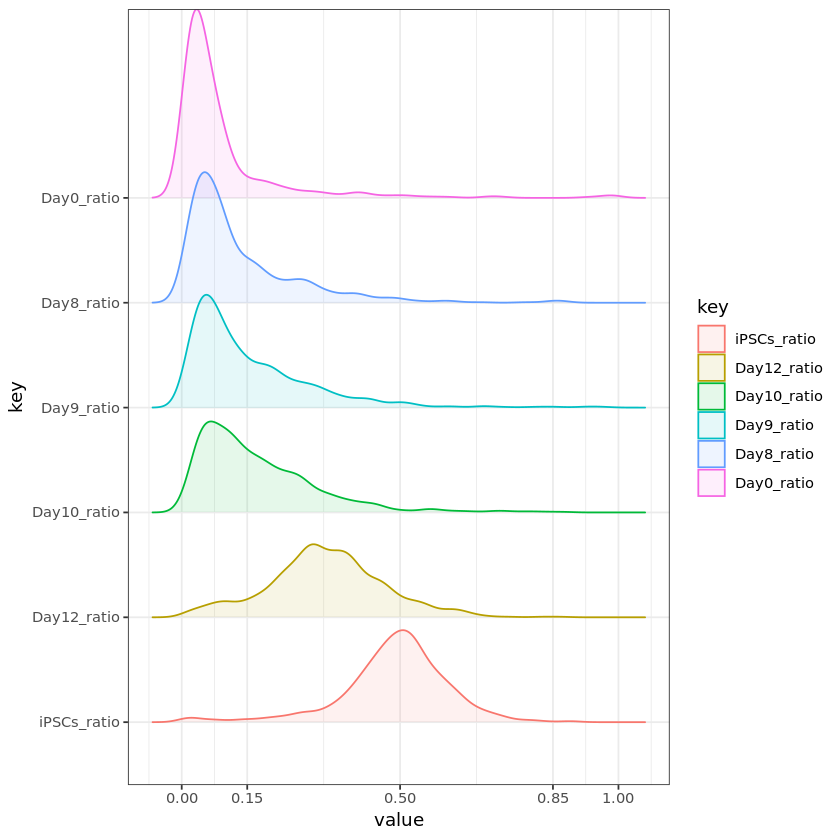

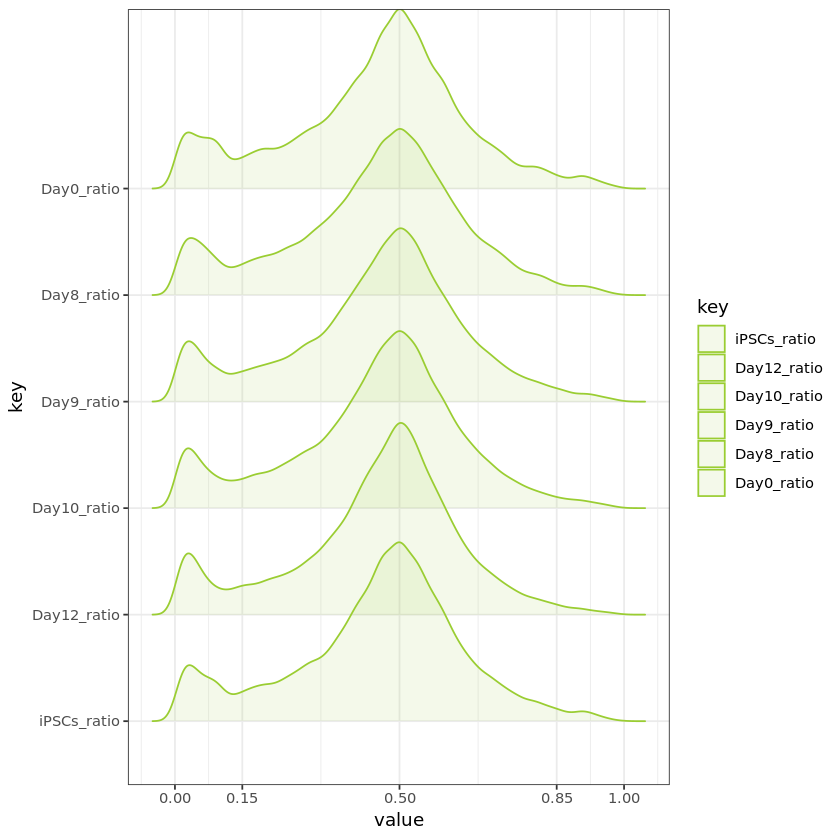

In [45]:
DF_allele_chrX_ratio_noNA_long <- tidyr::gather(DF_allele_chrX_ratio_noNA[,1:6])
DF_allele_chrX_ratio_noNA_long$key <- factor(DF_allele_chrX_ratio_noNA_long$key, levels = c("iPSCs_ratio","Day12_ratio","Day10_ratio","Day9_ratio","Day8_ratio","Day0_ratio"))
#Auto
DF_allele_Auto_ratio_noNA_long <- gather(DF_allele_Auto_ratio_noNA[,1:6])
DF_allele_Auto_ratio_noNA_long$key <- factor(DF_allele_Auto_ratio_noNA_long$key, levels = c("iPSCs_ratio","Day12_ratio","Day10_ratio","Day9_ratio","Day8_ratio","Day0_ratio"))

density <- ggplot(DF_allele_chrX_ratio_noNA_long, aes(x=value,y=key,fill= key, color = key)) +
   #geom_freqpoly(binwidth = 0.04, size = 0.8) +
  geom_density_ridges(alpha=0.1)+
  scale_x_continuous(breaks = c(0,0.15,0.5,0.85,1))+
  theme_bw()

density_Auto <- ggplot(DF_allele_Auto_ratio_noNA_long, aes(x=value,y=key, fill=key, color =key)) +
  geom_density_ridges(alpha=0.1)+
  scale_x_continuous(breaks = c(0,0.15,0.5,0.85,1))+
  scale_color_manual(values=c(rep(c("olivedrab3"),6)))+
  scale_fill_manual(values=c(rep(c("olivedrab3"),6)))+
  theme_bw()



density
density_Auto

In [30]:
ATAC_Allele_chrX_sorted_dynamics <- read_excel("ATAC_Allele_chrX_sorted_dynamics.xlsx")

New names:
* `` -> ...11


In [31]:
head(ATAC_Allele_chrX_sorted_dynamics)

Day0_ratio,Day8_ratio,Day9_ratio,Day10_ratio,Day12_ratio,iPSCs_ratio,start,end,width,names,...11
0.09090909,0.6315789,0.6153846,0.56716418,0.5483871,0.7000000,18186859,18187489,631,402098,day8
0.06666667,0.5454545,0.2400000,0.34375000,0.5271318,0.4369231,20794312,20794863,552,402286,day8
0.07142857,0.5454545,0.2857143,0.22222222,0.3636364,0.4791667,152149308,152149658,351,406951,day8
0.04761905,0.5000000,0.2083333,0.06666667,0.4571429,0.5000000,94048034,94048443,410,404527,day8
0.06451613,0.5000000,0.1250000,0.43478261,0.5416667,0.5081967,13485286,13486092,807,401914,day8
0.07547170,0.5000000,0.1707317,0.22580645,0.3488372,0.5694444,57674800,57675528,729,403196,day8


In [32]:
nrow(ATAC_Allele_chrX_sorted_dynamics)

[1] 750

In [33]:
colnames(ATAC_Allele_chrX_sorted_dynamics)[colnames(ATAC_Allele_chrX_sorted_dynamics)=="...11"] <- "kinetics"
nrow(subset(ATAC_Allele_chrX_sorted_dynamics,ATAC_Allele_chrX_sorted_dynamics$kinetics == "day8"))

[1] 159

In [34]:
head(ATAC_Allele_chrX_sorted_dynamics)

Day0_ratio,Day8_ratio,Day9_ratio,Day10_ratio,Day12_ratio,iPSCs_ratio,start,end,width,names,kinetics
0.09090909,0.6315789,0.6153846,0.56716418,0.5483871,0.7000000,18186859,18187489,631,402098,day8
0.06666667,0.5454545,0.2400000,0.34375000,0.5271318,0.4369231,20794312,20794863,552,402286,day8
0.07142857,0.5454545,0.2857143,0.22222222,0.3636364,0.4791667,152149308,152149658,351,406951,day8
0.04761905,0.5000000,0.2083333,0.06666667,0.4571429,0.5000000,94048034,94048443,410,404527,day8
0.06451613,0.5000000,0.1250000,0.43478261,0.5416667,0.5081967,13485286,13486092,807,401914,day8
0.07547170,0.5000000,0.1707317,0.22580645,0.3488372,0.5694444,57674800,57675528,729,403196,day8


In [35]:
ATAC_Allele_chrX_sorted_dynamics_long <- subset(ATAC_Allele_chrX_sorted_dynamics, select = c("Day0_ratio",
                                                                                             "Day8_ratio",
                                                                                             "Day9_ratio",
                                                                                             "Day10_ratio",
                                                                                             "Day12_ratio",
                                                                                             "iPSCs_ratio"))

In [36]:
head(ATAC_Allele_chrX_sorted_dynamics_long)

Day0_ratio,Day8_ratio,Day9_ratio,Day10_ratio,Day12_ratio,iPSCs_ratio
0.09090909,0.6315789,0.6153846,0.56716418,0.5483871,0.7000000
0.06666667,0.5454545,0.2400000,0.34375000,0.5271318,0.4369231
0.07142857,0.5454545,0.2857143,0.22222222,0.3636364,0.4791667
0.04761905,0.5000000,0.2083333,0.06666667,0.4571429,0.5000000
0.06451613,0.5000000,0.1250000,0.43478261,0.5416667,0.5081967
0.07547170,0.5000000,0.1707317,0.22580645,0.3488372,0.5694444


In [37]:
ATAC_Allele_chrX_sorted_dynamics_long <- gather(ATAC_Allele_chrX_sorted_dynamics_long)

In [38]:
ATAC_Allele_chrX_sorted_dynamics_long$key <- factor(ATAC_Allele_chrX_sorted_dynamics_long$key, levels = c("Day0_ratio",
                                                                                             "Day8_ratio",
                                                                                             "Day9_ratio",
                                                                                             "Day10_ratio",
                                                                                             "Day12_ratio",
                                                                                             "iPSCs_ratio"))

In [39]:
head(ATAC_Allele_chrX_sorted_dynamics_long)

key,value
Day0_ratio,0.09090909
Day0_ratio,0.06666667
Day0_ratio,0.07142857
Day0_ratio,0.04761905
Day0_ratio,0.06451613
Day0_ratio,0.07547170


In [40]:
ATAC_Allele_chrX_sorted_dynamics_long$kinetics <- rep(ATAC_Allele_chrX_sorted_dynamics$kinetics,6)

In [41]:
head(ATAC_Allele_chrX_sorted_dynamics_long)

key,value,kinetics
Day0_ratio,0.09090909,day8
Day0_ratio,0.06666667,day8
Day0_ratio,0.07142857,day8
Day0_ratio,0.04761905,day8
Day0_ratio,0.06451613,day8
Day0_ratio,0.07547170,day8


In [51]:
class(ATAC_Allele_chrX_sorted_dynamics_long$value)

[1] "numeric"

In [46]:
nrow(subset(ATAC_Allele_chrX_sorted_dynamics,ATAC_Allele_chrX_sorted_dynamics$kinetics == "Escapee"))
nrow(subset(ATAC_Allele_chrX_sorted_dynamics,ATAC_Allele_chrX_sorted_dynamics$kinetics == "day8"))
nrow(subset(ATAC_Allele_chrX_sorted_dynamics,ATAC_Allele_chrX_sorted_dynamics$kinetics == "day9"))

[1] 109

[1] 159

[1] 88

In [43]:
ATAC_early <- subset(ATAC_Allele_chrX_sorted_dynamics_long, ATAC_Allele_chrX_sorted_dynamics_long$kinetics == "day8")
ATAC_early$group <- rep(c(1:159),6)
ATAC_day9 <- subset(ATAC_Allele_chrX_sorted_dynamics_long, ATAC_Allele_chrX_sorted_dynamics_long$kinetics == "day9")
ATAC_day9$group <- rep(c(1:88),6)
ATAC_day10 <- subset(ATAC_Allele_chrX_sorted_dynamics_long, ATAC_Allele_chrX_sorted_dynamics_long$kinetics == "day10")
ATAC_day10$group <- rep(c(1:86),6)
ATAC_day12 <- subset(ATAC_Allele_chrX_sorted_dynamics_long, ATAC_Allele_chrX_sorted_dynamics_long$kinetics == "day12")
ATAC_day12$group <- rep(c(1:251),6)
ATAC_iPSCs <- subset(ATAC_Allele_chrX_sorted_dynamics_long, ATAC_Allele_chrX_sorted_dynamics_long$kinetics == "iPSCs")
ATAC_iPSCs$group <- rep(c(1:35),6)
ATAC_closed <- subset(ATAC_Allele_chrX_sorted_dynamics_long, ATAC_Allele_chrX_sorted_dynamics_long$kinetics == "Closed")
ATAC_closed$group <- rep(c(1:15),6)
ATAC_escapee <- subset(ATAC_Allele_chrX_sorted_dynamics_long, ATAC_Allele_chrX_sorted_dynamics_long$kinetics == "Escapee")
ATAC_escapee$group <- rep(c(1:109),6)

In [47]:
ATAC_early

key,value,kinetics,group
Day0_ratio,0.09090909,day8,1
Day0_ratio,0.06666667,day8,2
Day0_ratio,0.07142857,day8,3
Day0_ratio,0.04761905,day8,4
Day0_ratio,0.06451613,day8,5
Day0_ratio,0.07547170,day8,6
Day0_ratio,0.09090909,day8,7
Day0_ratio,0.05128205,day8,8
Day0_ratio,0.10638298,day8,9
Day0_ratio,0.01388889,day8,10


In [49]:
head(ATAC_escapee)

key,value,kinetics,group
Day0_ratio,0.1538462,Escapee,1
Day0_ratio,0.1538462,Escapee,2
Day0_ratio,0.1538462,Escapee,3
Day0_ratio,0.1538462,Escapee,4
Day0_ratio,0.1538462,Escapee,5
Day0_ratio,0.1538462,Escapee,6


In [50]:
class(ATAC_escapee$value)

[1] "numeric"

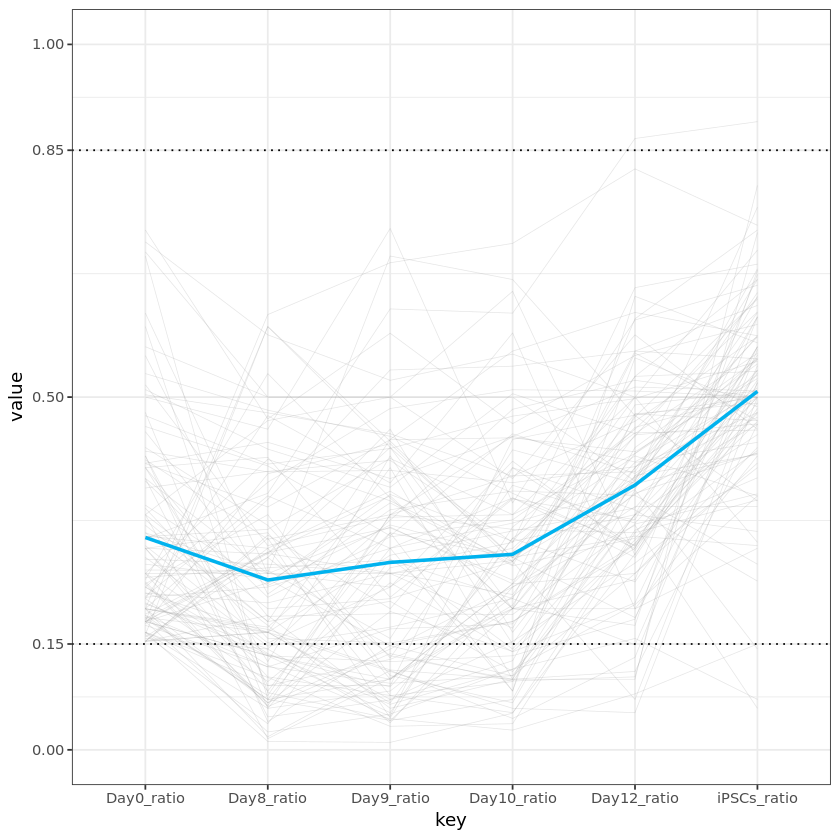

In [48]:
ATAC_chrX_kinetics_escapee <- ggplot(ATAC_escapee , aes(x=key,y=value, color = kinetics, group = group))+
                            geom_line(colour = "grey60", size =0.2, alpha = 0.25)+
                            stat_summary(aes(group=kinetics), fun.y=mean, geom="line",colour = "deepskyblue2", size = 1)+
                            scale_y_continuous(breaks = c(0.0,0.15,0.5,0.85,1), limits=c(0.0,1))+
                            geom_hline(yintercept=0.15,linetype="dotted")+
                            geom_hline(yintercept=0.85,linetype="dotted")+
                            theme_bw() 


ATAC_chrX_kinetics_escapee

New names:
* `` -> ...11


[1] 0

[1] 120

Picking joint bandwidth of 0.0152


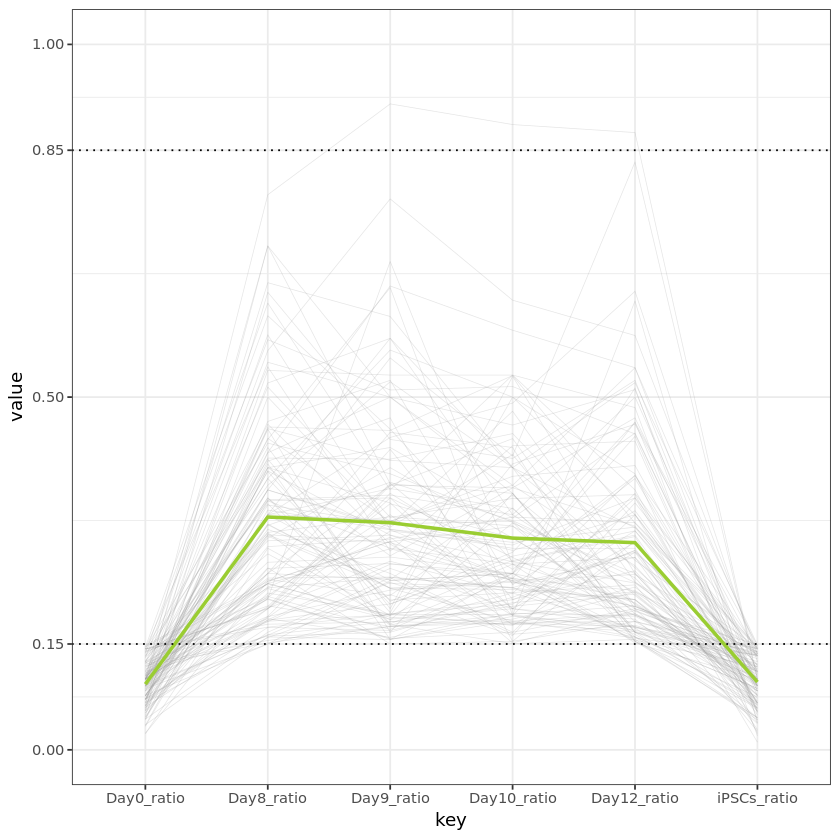

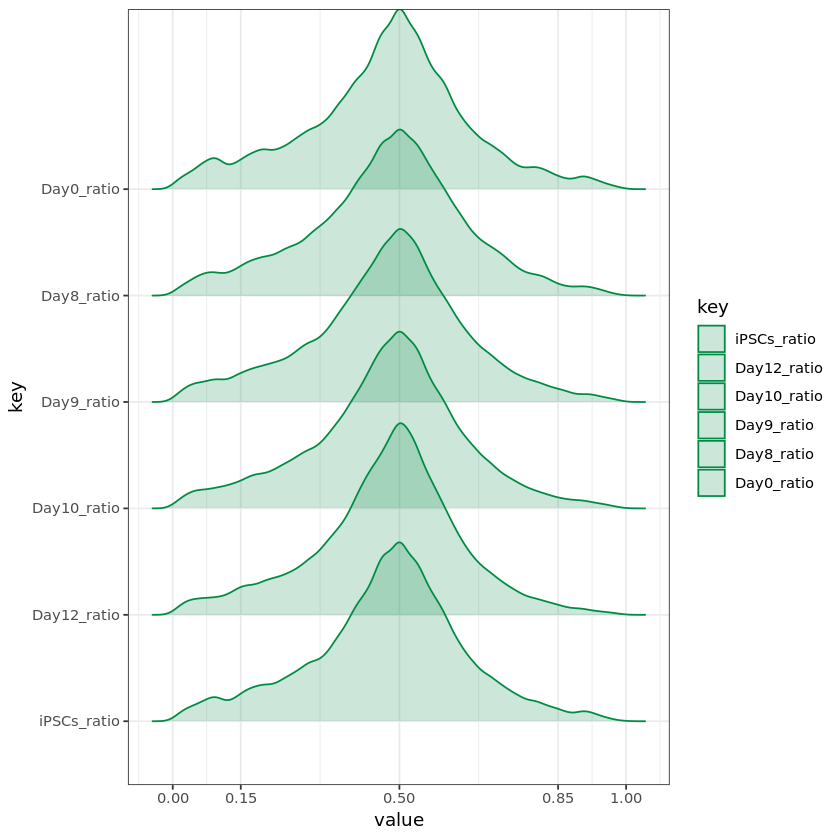

In [53]:
#### Sort the regions based on the d score and the timing of re-opening. Autosomal genes.


#Import sorted values
ATAC_Allele_Auto_sorted_dynamics <- read_excel("ATAC_Allele_Auto_sorted_dynamics.xlsx")

# Plotting the dynamics of allelic accessibility changes (DF preparation) 1/2 Auto
colnames(ATAC_Allele_Auto_sorted_dynamics)[colnames(ATAC_Allele_Auto_sorted_dynamics)=="...11"] <- "kinetics"
nrow(subset(ATAC_Allele_Auto_sorted_dynamics,ATAC_Allele_Auto_sorted_dynamics$kinetics == "day8"))

ATAC_Allele_Auto_sorted_dynamics_long <- subset(ATAC_Allele_Auto_sorted_dynamics, select = c("Day0_ratio",
                                                                                             "Day8_ratio",
                                                                                             "Day9_ratio",
                                                                                             "Day10_ratio",
                                                                                             "Day12_ratio",
                                                                                             "iPSCs_ratio"))

ATAC_Allele_Auto_sorted_dynamics_long <- gather(ATAC_Allele_Auto_sorted_dynamics_long)
ATAC_Allele_Auto_sorted_dynamics_long$key <- factor(ATAC_Allele_Auto_sorted_dynamics_long$key, levels = c("Day0_ratio",
                                                                                             "Day8_ratio",
                                                                                             "Day9_ratio",
                                                                                             "Day10_ratio",
                                                                                             "Day12_ratio",
                                                                                             "iPSCs_ratio"))
ATAC_Allele_Auto_sorted_dynamics_long$kinetics <- rep(ATAC_Allele_Auto_sorted_dynamics$kinetics,6)

# Plotting the dynamics of allelic accessibility changes (grouping + plotting) 2/2 Auto
nrow(subset(ATAC_Allele_Auto_sorted_dynamics,ATAC_Allele_Auto_sorted_dynamics$kinetics == "Day8_9_10_12"))

ATAC_Auto1 <- subset(ATAC_Allele_Auto_sorted_dynamics_long, ATAC_Allele_Auto_sorted_dynamics_long$kinetics == "closed")
ATAC_Auto1$group <- rep(c(1:3404),6)
ATAC_Auto2 <- subset(ATAC_Allele_Auto_sorted_dynamics_long, ATAC_Allele_Auto_sorted_dynamics_long$kinetics == "ALL_BI")
ATAC_Auto2$group <- rep(c(1:52976),6)
ATAC_Auto3 <- subset(ATAC_Allele_Auto_sorted_dynamics_long, ATAC_Allele_Auto_sorted_dynamics_long$kinetics == "Day8_ON")
ATAC_Auto3$group <- rep(c(1:1128),6)
ATAC_Auto4 <- subset(ATAC_Allele_Auto_sorted_dynamics_long, ATAC_Allele_Auto_sorted_dynamics_long$kinetics == "Day9_ON")
ATAC_Auto4$group <- rep(c(1:90),6)
ATAC_Auto5 <- subset(ATAC_Allele_Auto_sorted_dynamics_long, ATAC_Allele_Auto_sorted_dynamics_long$kinetics == "Day10_ON")
ATAC_Auto5$group <- rep(c(1:47),6)
ATAC_Auto6 <- subset(ATAC_Allele_Auto_sorted_dynamics_long, ATAC_Allele_Auto_sorted_dynamics_long$kinetics == "Day12_ON")
ATAC_Auto6$group <- rep(c(1:89),6)
ATAC_Auto7 <- subset(ATAC_Allele_Auto_sorted_dynamics_long, ATAC_Allele_Auto_sorted_dynamics_long$kinetics == "openIPSC")
ATAC_Auto7$group <- rep(c(1:681),6)
ATAC_Auto8 <- subset(ATAC_Allele_Auto_sorted_dynamics_long, ATAC_Allele_Auto_sorted_dynamics_long$kinetics == "Day9_Day10_only")
ATAC_Auto8$group <- rep(c(1:30),6)
ATAC_Auto9 <- subset(ATAC_Allele_Auto_sorted_dynamics_long, ATAC_Allele_Auto_sorted_dynamics_long$kinetics == "Day8_9_10_12")
ATAC_Auto9$group <- rep(c(1:120),6)

ATAC_Auto_kinetics_Day8_9_10_12 <- ggplot(ATAC_Auto9 , aes(x=key,y=value, color = kinetics, group = group))+
                            geom_line(colour = "grey60", size =0.2, alpha = 0.25)+
                            stat_summary(aes(group=kinetics), fun.y=mean, geom="line",colour = "olivedrab3", size = 1)+
                            scale_y_continuous(breaks = c(0.0,0.15,0.5,0.85,1), limits=c(0.0,1))+
                            geom_hline(yintercept=0.15,linetype="dotted")+
                            geom_hline(yintercept=0.85,linetype="dotted")+
                            theme_bw() 


ATAC_Auto_kinetics_Day8_9_10_12


ATAC_Auto_no_closed <- subset(ATAC_Allele_Auto_sorted_dynamics_long, ATAC_Allele_Auto_sorted_dynamics_long$kinetics != "closed")
ATAC_Auto_no_closed$key <- factor(ATAC_Auto_no_closed$key, levels = c("iPSCs_ratio",
                                                                                             "Day12_ratio",
                                                                                             "Day10_ratio",
                                                                                             "Day9_ratio",
                                                                                             "Day8_ratio",
                                                                                             "Day0_ratio"))

density_Auto_noclosed <- ggplot(ATAC_Auto_no_closed, aes(x=value,y=key, fill=key, color =key)) +
   #geom_freqpoly(binwidth = 0.04, size = 0.8) +
  geom_density_ridges(alpha=0.2)+
  scale_x_continuous(breaks = c(0,0.15,0.5,0.85,1))+
  scale_color_manual(values=c(rep(c("springgreen4"),6)))+
  scale_fill_manual(values=c(rep(c("springgreen4"),6)))+
  theme_bw()
density_Auto_noclosed